# Amazon review analysis - Machin learning final project

### In this project, we aimed to build a mechanism to predict the main aspect of Amazon review from several aspects. 

- After loading and basic analysis of Amazon review data, we used one-shot classification to generate the data and used this data to train an ANN to create weight to use them for predicting reviews at a lower cost. 
- First, we used OpemnAI embeddings to embed a sample of reviews and embed pre-defined a set of 10 common product aspects.
- Using cosign similarity, we found the closest vectors and found the most common aspect for each review. 
- We used the one-shot classification to find the main aspects

## First step - Create a sample of the Amazon reviews dataset

Create a list of categories and the sample size of each category to create a review sample of 1M reviews that represent the Amazon review dataset. The sample will include the same ratio as the original full data set.

In [24]:
# Load a metadata of the list of all categories in the dataset of Amazon-Reviews-2023 from HuggingFace
all_categories_list = pd.read_csv('all_categories_list.csv')
all_categories_list.head()

Category   #User   #Item #Rating #R_Token #M_Token  \
0              All_Beauty  632.0K  112.6K  701.5K    31.6M    74.1M   
1          Amazon_Fashion    2.0M  825.9K    2.5M    94.9M   510.5M   
2              Appliances    1.8M   94.3K    2.1M    92.8M    95.3M   
3  Arts_Crafts_and_Sewing    4.6M  801.3K    9.0M   350.0M   695.4M   
4              Automotive    8.0M    2.0M   20.0M   824.9M     1.7B   

       Download  
0  review, meta  
1  review, meta  
2  review, meta  
3  review, meta  
4  review, meta

In [3]:
# Calculate the number of ratings for each category usign the #Rating column. Multiply numbet by the letters K, M, B, T to get the actual number of ratings
all_categories_list['reitings_num'] = all_categories_list['#Rating'].str.replace('K', '*1000').str.replace('M', '*1000000').str.replace('B', '*1000000000').str.replace('T', '*1000000000000').map(pd.eval).astype(int)
all_categories_list['ratio'] = all_categories_list['reitings_num'] / all_categories_list['reitings_num'].sum()
all_categories_list['sampe_size'] = round(all_categories_list['ratio'] * 1000000, 0).astype(int)

In [8]:
# create a list of list for category and sample size
categories_list = all_categories_list[['Category', 'sampe_size']].values.tolist()
categories_list[0:10]

[['All_Beauty', 1228],
 ['Amazon_Fashion', 4375],
 ['Appliances', 3675],
 ['Arts_Crafts_and_Sewing', 15750],
 ['Automotive', 35000],
 ['Baby_Products', 10500],
 ['Beauty_and_Personal_Care', 41825],
 ['Books', 51625],
 ['CDs_and_Vinyl', 8400],
 ['Cell_Phones_and_Accessories', 36400]]

In [10]:
import datetime

# Create unix time for Jan 1, 2010
dt = datetime.datetime(year=2010, month=1, day=1)
unix_time_2010 = int(dt.timestamp())

## Download a sample of the dataset
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

In [143]:
from datetime import datetime
from datasets import load_dataset

def load_and_get_sampled_data(category_samples):
    '''
    Stream data for specified categories with specified sample sizes, filter by timestamp and rating, and sample entries.
    Parameters: category_samples (list of lists): Each inner list contains a category name and its sample size.
    Returns: list of pandas.DataFrame: A list of sampled data DataFrames with the columns ['category', 'dt', 'review']
    '''
    result = []

    for entry in category_samples:
        cat, sample_size = entry

        # Enable streaming
        raw_review_stream = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{cat}", split="full", streaming=True, trust_remote_code=True)

        # Filter and collect sampled data
        sampled_reviews = []
        for review in raw_review_stream:
            if (review['timestamp'] > unix_time_2010 and review['rating'] < 3 and len(review['text']) > 10):
                # Extract year and month from timestamp
                dt = review['timestamp']
                
                # Append the category, year, month, and text to the sampled_reviews list
                sampled_reviews.append({
                    'category': cat, 
                    'dt': dt,
                    'review': review['text']
                })
                
            if len(sampled_reviews) == sample_size:
                break

        # Convert list of dictionaries to DataFrame
        if sampled_reviews:
            df = pd.DataFrame(sampled_reviews)
            result.append(df[['category', 'dt', 'review']])
        else:
            result.append(pd.DataFrame(columns=['category', 'dt', 'review']))

    return result

In [144]:
import pickle
import time
import os

start_time = time.time()
sample_reviews = None

# Check if the file exists before attempting to load
if os.path.exists('sample_reviews.pkl'):
    try:
        with open('sample_reviews.pkl', 'rb') as f:
            sample_reviews = pickle.load(f)
    except Exception as e:
        print("Error loading data from pickle:", e)
else:
    try:
        sample_reviews = load_and_get_sampled_data(categories_list)
        with open('sample_reviews.pkl', 'wb') as f:
            pickle.dump(sample_reviews, f)
    except Exception as e:
        print("Error during data processing or saving:", e)

if sample_reviews is not None:
    print(f"Time taken: {round(time.time() - start_time, 2)} seconds")
    print(f"Time taken: {round(time.time() - start_time/60,2)} minutes")
    print(f"Number of categories: {len(sample_reviews)}")
    print(f"Number of reviews: {sum([len(reviews) for reviews in sample_reviews])}")
else:
    print("Failed to load or generate reviews data.")

Time taken: 1221.14 seconds
Time taken: 20.352333333333334 minutes
Number of categories: 34
Number of reviews: 1000003


In [160]:
# Convert timstamp to datetime and extract year and month
for reviews in sample_reviews:
    reviews['dt'] = pd.to_datetime(reviews['dt'], unit='ms')
    reviews['year'] = reviews['dt'].dt.year
    reviews['month'] = reviews['dt'].dt.month

In [313]:
all_reviews = pd.concat(sample_reviews, ignore_index=True)

# Print a sample of the first 5 reviews for each category
with pd.option_context('display.max_colwidth', 500):
    for reviews in sample_reviews:
        print(f"Category: {reviews['category'].iloc[0]}")
        print(reviews['review'].head(5).values)
        print()

Category: All_Beauty
['Felt synthetic'
 'nothing special  unfortunately i waited too long to return them ....  no results at all  dont waste your money'
 "I think I need to stick with my 5 blade razor. This razor is not only difficult to hold & is made of a hard slick plastic with no grippers, but doesn't shave as well as my 5 blade razor. The style is nice, but the functionality is not."
 'A total waste of money.  I get better results using a tea bag to alleviate under eye swelling.'
 "This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY better in the photos than in real life.  The color is horrific, in my opinion of course.  The streaks are like paint strips.  And all of that would be one thing - but the worst is that the hair completely fell out!  I had hand fulls of hair strands just trying to put the halo on!  And you might think - wel

A list of all categories and it's sample size percentage

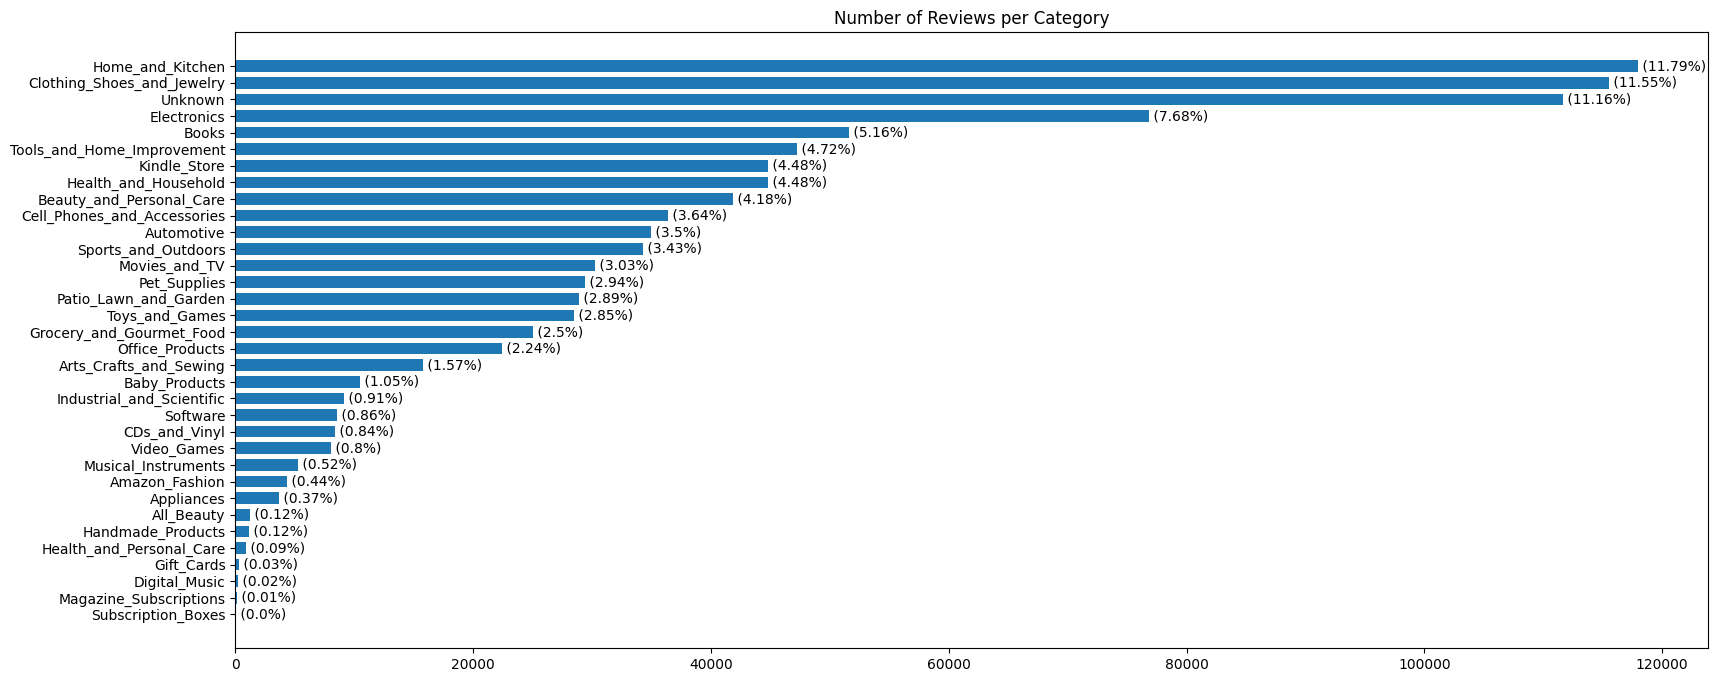

In [152]:
# Plot the number of reviews per category
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the categories by number of reviews
sorted_categories = sorted(categories_list, key=lambda x: x[1])

# Create a list of number of reviews per category in the sorted order
num_reviews_per_category = [entry[1] for entry in sorted_categories]

plt.figure(figsize=(19, 8))  # Increase the size of the plot frame
plt.barh([entry[0] for entry in sorted_categories], num_reviews_per_category, height=0.7)  # Add height parameter to create space between bars
plt.title('Presentage of Reviews per Category')
plt.yticks(range(len(sorted_categories)), [entry[0] for entry in sorted_categories])
for i, v in enumerate(num_reviews_per_category):
  plt.text(v, i, f' ({round((v/sum(num_reviews_per_category))*100, 2)}%)', va='center')
plt.show()

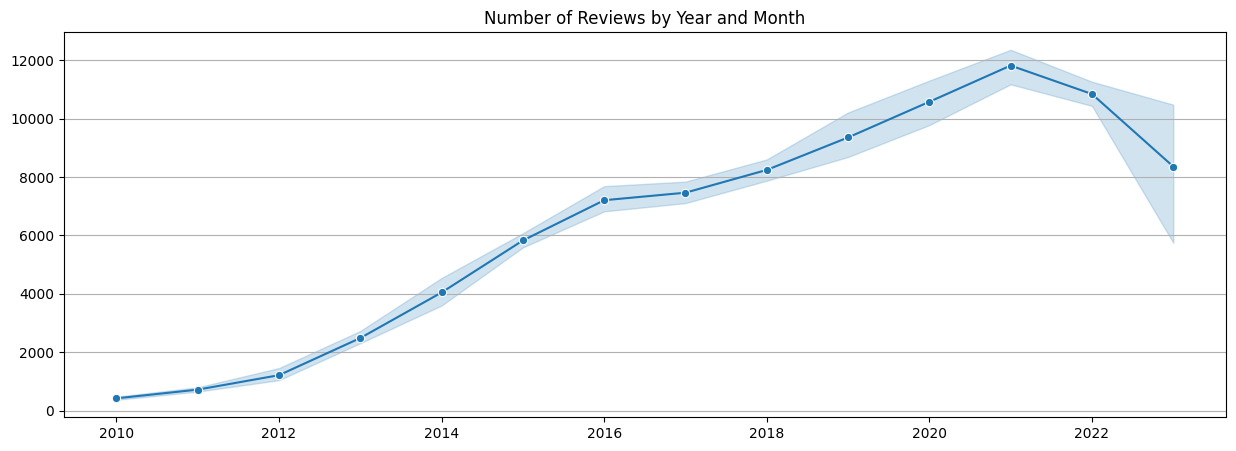

In [214]:
# Group the reviews by year and month
reviews_by_month = all_reviews.groupby(['year', 'month']).size().reset_index(name='count')
# Filter from 2010 only
reviews_by_month = reviews_by_month[reviews_by_month['year'] >= 2010]

# Plot the number of reviews by year and month
plt.figure(figsize=(15, 5))
sns.lineplot(data=reviews_by_month, x='year', y='count', marker='o')
plt.title('Number of Reviews by Year and Month')
plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y')
plt.show()

We can see the categories where users are using more words in order to express themselves and categories where users use less words to express themselves in the product reviews.

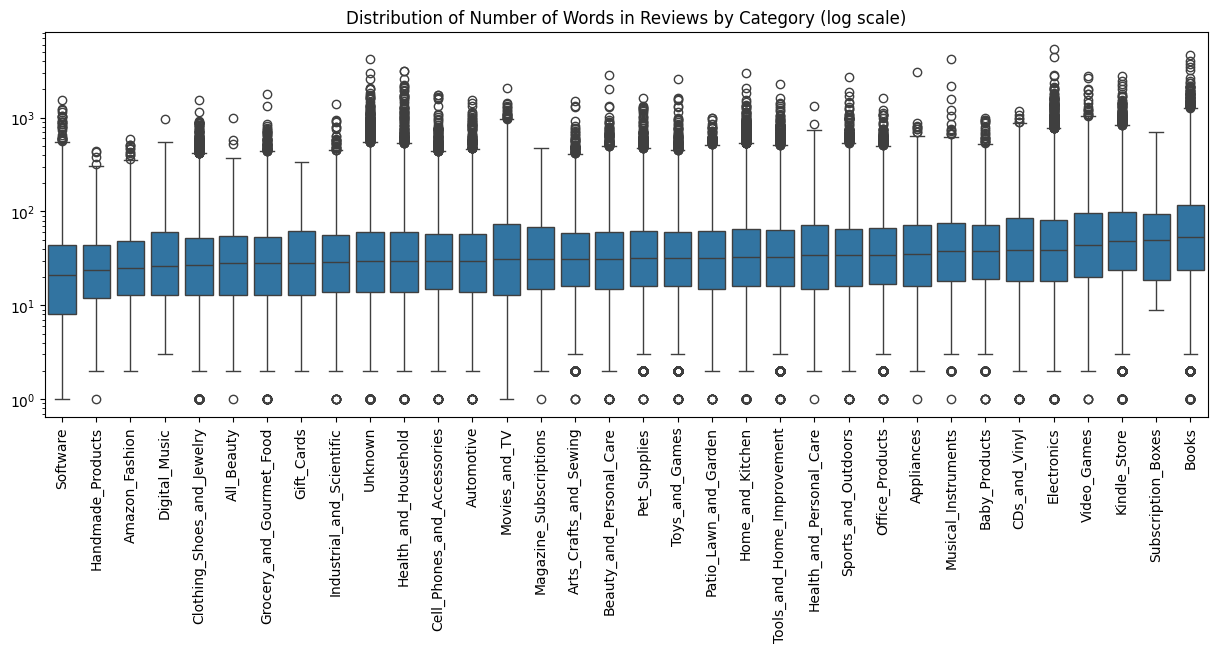

In [314]:
# Plot the ditribution of review number of words by category using boxplot
# Calculate the number of words in each review
all_reviews['num_words'] = all_reviews['review'].str.split().apply(len)

# Sort categories by median number of words in reviews
sorted_categories_by_median = all_reviews.groupby('category')['num_words'].median().sort_values().index

# Create a boxplot of the number of words in reviews by category
plt.figure(figsize=(15, 5))
sns.boxplot(data=all_reviews, x='category', y='num_words', order=sorted_categories_by_median, log_scale=True)
plt.title('Distribution of Number of Words in Reviews by Category (log scale)')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

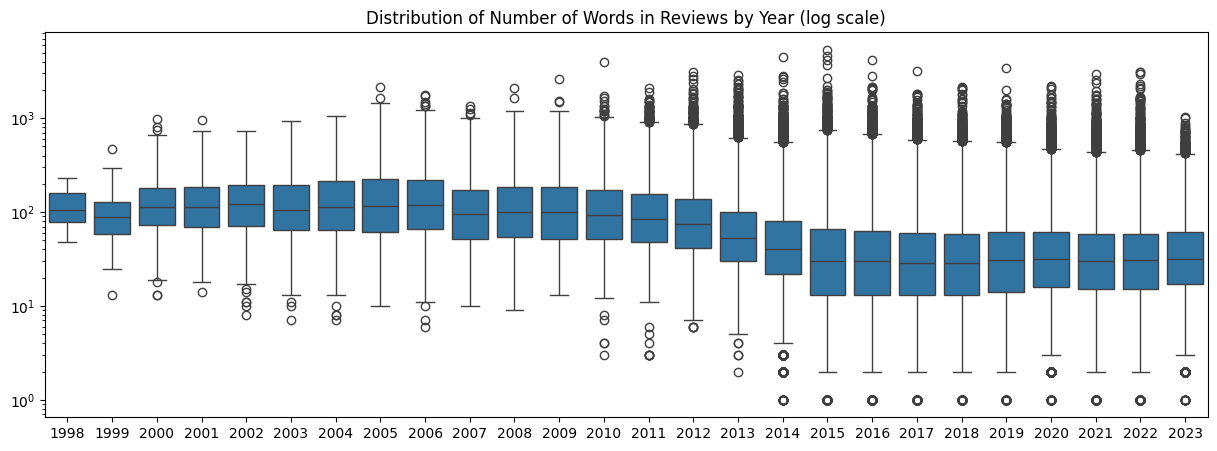

In [216]:
# Plot the ditribution of review number of words by year using boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(data=all_reviews, x='year', y='num_words', log_scale=True)
plt.title('Distribution of Number of Words in Reviews by Year (log scale)')
plt.xlabel('')
plt.ylabel('')
plt.show()

Pre processing the text using gensim

In [315]:
# Clean text - Remove non-english characters, punctuation marks, extra spaces, numbers, HTML signs
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, preprocess_string

def clean_text_gensim(text):
    # Define a list of preprocessing functions to apply
    filters = [strip_punctuation, strip_numeric, remove_stopwords, lambda x: x.lower()]
    
    # Apply preprocessing
    clean_text = preprocess_string(text, filters)
    
    # Join the tokens back into a single string
    clean_text = ' '.join(clean_text)
    
    return clean_text

# Apply the cleaning function to the reviews
all_reviews['clean_review'] = all_reviews['review'].apply(clean_text_gensim)

In [195]:
import tiktoken

embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"

encoding = tiktoken.get_encoding(embedding_encoding)
encoding = tiktoken.encoding_for_model(embedding_model)

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

print("Avrage tockens per review: ", round(all_reviews['clean_review'].apply(lambda x: num_tokens_from_string(x, embedding_encoding)).mean(),2))

Avrage tockens per review:  31.81


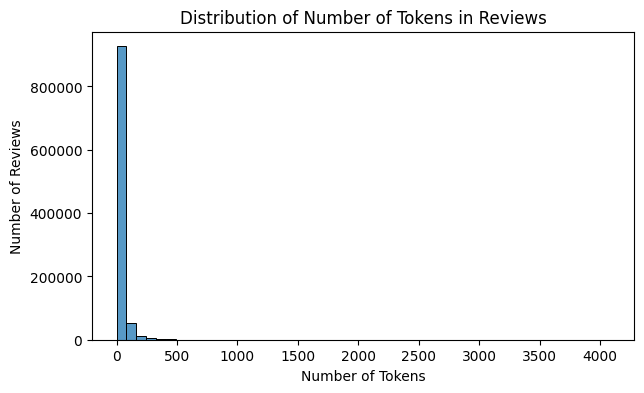

In [196]:
# Histogram of number of tokens among the reviews

plt.figure(figsize=(7, 4))
sns.histplot(all_reviews['clean_review'].apply(lambda x: num_tokens_from_string(x, embedding_encoding)), bins=50)
plt.title('Distribution of Number of Tokens in Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.show()

In [316]:
review_num = len(all_reviews)

# Filter years later then 2010
all_reviews = all_reviews[all_reviews['year'] >= 2010]

# Remove reviews with more than  256 tokens
all_reviews = all_reviews[all_reviews['clean_review'].apply(lambda x: num_tokens_from_string(x, embedding_encoding)) <= 256]

all_reviews['clean_review'] = (
    all_reviews['clean_review']
    .str.replace(r'\b\w\b', '')  # Remove single-character words
    .str.replace(r'\bbr\b', '', regex=True)        # Remove "br"
    .str.replace(r'\s+', ' ')    # Reduce multiple spaces to a single space
    .str.strip()                 # Remove leading and trailing spaces
)

print(f"Removed {review_num - len(all_reviews)} reviews.")

Removed 18295 reviews.


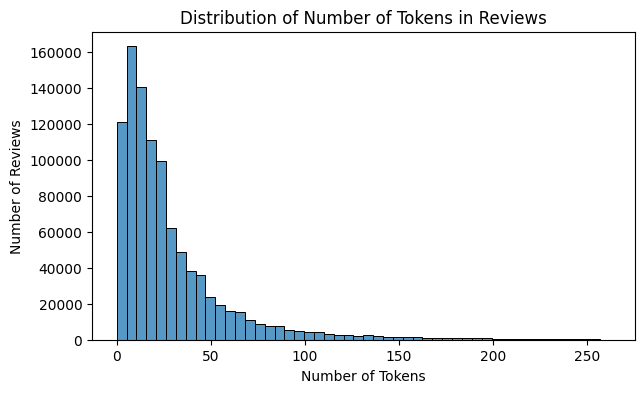

In [219]:
# Histogram of number of tokens among the reviews

plt.figure(figsize=(7, 4))
sns.histplot(all_reviews['clean_review'].apply(lambda x: num_tokens_from_string(x, embedding_encoding)), bins=50)
plt.title('Distribution of Number of Tokens in Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.show()

In [318]:
# smaple reviews
all_reviews_sample = all_reviews.sample(n=100000, random_state=42)

In [9]:
import openai

open_ai_key_path = r"C:\Users\naama\Desktop\Chen\Secret keys\OpenAI_API.txt"
OPENAI_API_KEY = open(open_ai_key_path, 'r').read()
# client = openai.OpenAI(api_key=OPENAI_API_KEY)
openai.api_key = OPENAI_API_KEY

In [225]:
%%time
price_large_model = 0.13
price_small_model = 0.02
all_strings = '\n'.join(all_reviews_sample['clean_review'].to_list())
number_of_tokens = num_tokens_from_string(all_strings, encoding_name="cl100k_base")

print(f"Number of tokens: {number_of_tokens}")
print(f"Astimeated cost for large model: ${number_of_tokens/1e6*price_large_model:2.2f}")
print(f"Astimeated cost for small model: ${number_of_tokens/1e6*price_small_model:2.2f}")

Number of tokens: 2981679
Astimeated cost for large model: $0.39
Astimeated cost for small model: $0.06
CPU times: total: 578 ms
Wall time: 3.35 s


In [ ]:
from langchain_openai import OpenAIEmbeddings

openai_client = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model="text-embedding-3-small")

In [ ]:
def process_embeddings_in_chunks(data, chunk_size=1000):
    total_len = len(data)
    embeddings = []

    for i in range(0, total_len, chunk_size):
        end_index = min(i + chunk_size, total_len)  # Ensure we don't go out of bounds
        # Process each chunk
        try:
            chunk_embeddings = openai_client.embed_documents(data[i:end_index], chunk_size=chunk_size)
            embeddings.extend(chunk_embeddings)
        except Exception as e:
            print(f"Error processing chunk from {i} to {end_index}: {e}")
            # Extend with None or appropriate placeholders if needed
            embeddings.extend([None] * (end_index - i))

    return embeddings

In [231]:
start_time = time.time()

# Check if the file exists before attempting to load
if os.path.exists('all_reviews_sample_embeddings.pkl'):
    try:
        with open('all_reviews_sample_embeddings.pkl', 'rb') as f:
            all_reviews_sample = pickle.load(f)
    except Exception as e:
        print("Error loading data from pickle:", e)
else:
    try:
        all_reviews_embeddings = process_embeddings_in_chunks(all_reviews_sample['clean_review'].to_list(), chunk_size=1000)
        with open('all_reviews_sample_embeddings.pkl', 'wb') as f:
            pickle.dump(all_reviews_sample, f)
    except Exception as e:
        print("Error during data processing or saving:", e)

if all_reviews_sample is not None:
    elapsed_time = time.time() - start_time
    print(f"Time taken: {round(elapsed_time, 2)} seconds")
    print(f"Time taken: {round(elapsed_time / 60, 2)} minutes")
    print(f"Number of categories: {len(all_reviews_sample)}")
    # Correct this line according to the actual structure of all_reviews_sample
    print(f"Number of reviews: {len(all_reviews_sample['clean_review'])}")
else:
    print("Failed to load or generate reviews data.")

Time taken: 862.7 seconds
Time taken: 14.38 minutes
Number of categories: 100000
Number of reviews: 100000


In [ ]:
all_reviews_sample['embeddings'] = all_reviews_embeddings
all_reviews_sample.drop(columns=['dt'])
all_reviews_sample

Common themes in product feedback:

1. Product Quality: Encompasses aspects of construction, durability, and material quality.
2. Fit and Comfort: Particularly useful for clothing, shoes, or accessories, focusing on how well the product fits and feels during use.
3. Product Functionality: How well the product performs its intended function.
4 .Value for Money: Reflects opinions on whether the product is worth the cost or not.
5. Customer Service: Experiences with the seller's customer service, including responsiveness and problem resolution.
6. Shipping and Delivery: Timeliness and condition of the product upon arrival.
7. Product Authenticity: Whether the product matches the description and expectations set by the brand or seller.
8. Usability: Ease of use and accessibility of the product.
9. Aesthetic and Design: Visual appeal and stylistic aspects of the product.
10. Packaging: Quality and adequacy of the packaging, including issues related to damage or waste.

In [2]:
aspects = [
    "Product Quality: Construction, durability, material",
    "Fit and Comfort: Fit quality and comfort during use",
    "Functionality: Performance of intended functions",
    "Value: Cost worthiness",
    "Customer Service: Support quality and issue resolution",
    "Shipping: Delivery timeliness and condition",
    "Authenticity: Matches description and expectations",
    "Usability: Ease of use and accessibility",
    "Design: Visual appeal and style",
    "Packaging: Quality, damage, and waste concerns"
]

In [19]:
def get_embeddings(texts, model="text-embedding-3-small"):
    try:
        openai.api_key = OPENAI_API_KEY
        responses = openai.Embedding.create(
            input=texts,
            model=model
        )
        # Extracting the embedding vectors from the responses
        return [response['data'] for response in responses['data']]
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

In [ ]:
aspect_embeddings = get_embeddings(aspects)

In [320]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between two vectors
def calculate_similarity_scores(embeddings, aspect_vector):
    scores = [1 - cosine(embedding, aspect_vector) for embedding in embeddings]
    return scores

# Create column for each ambedding aspect based of the cosinsimilarity to the reviews embeddings
for i, aspect in enumerate(aspects):
    all_reviews_sample[aspect] = calculate_similarity_scores(all_reviews_sample['embeddings'], aspect_embeddings[i])

# for each review, add main_aspect column 
all_reviews_sample['main_aspect'] = all_reviews_sample[aspects].idxmax(axis=1)

In [330]:
all_reviews_sample['main_aspect'].value_counts()

main_aspect
Packaging: Quality, damage, and waste concerns            19488
Fit and Comfort: Fit quality and comfort during use       18338
Product Quality: Construction, durability, material       14284
Authenticity: Matches description and expectations        13042
Value: Cost worthiness                                    11088
Shipping: Delivery timeliness and condition                9699
Design: Visual appeal and style                            6123
Customer Service: Support quality and issue resolution     3470
Functionality: Performance of intended functions           3250
Usability: Ease of use and accessibility                   1218
Name: count, dtype: int64

In [323]:
import pacmap
import numpy as np

pacmap_embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=4.0) 
X_transformed = pacmap_embedding.fit_transform(np.stack(all_reviews_sample['embeddings']), init="pca")

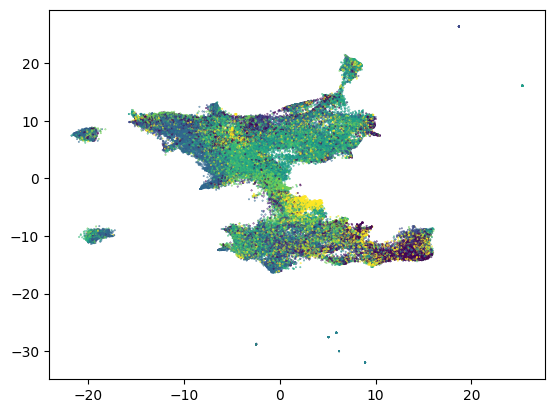

In [246]:
all_reviews_sample['main_aspect'] = all_reviews_sample['main_aspect'].astype('category')
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.1, c=all_reviews_sample['main_aspect'].cat.codes)

In [324]:
from openTSNE import TSNE

tsne_embedding_model = TSNE(perplexity=30,
    metric="cosine",
    n_jobs=os.cpu_count(),
    random_state=42,
    verbose=False)
tsne_embeddings = tsne_embedding_model.fit(np.stack(all_reviews_sample['embeddings']))

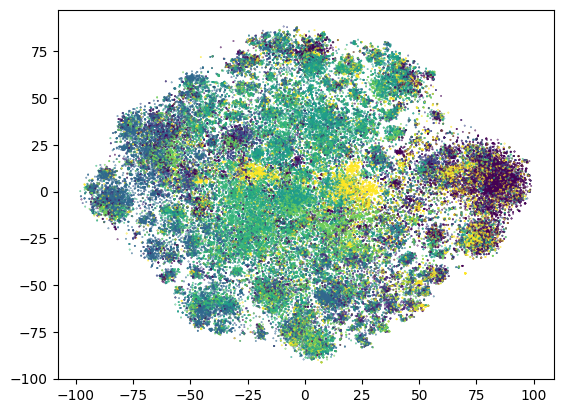

In [255]:
plt.scatter(tsne_embeddings[:,0], 
      tsne_embeddings[:,1], 
      s=0.1, 
      c=all_reviews_sample['main_aspect'].astype('category').cat.codes)

In [ ]:
plt.scatter(tsne_embeddings[:,0], 
      tsne_embeddings[:,1], 
      s=0.1, 
      c=all_reviews_sample['category'].astype('category').cat.codes)

In [337]:
# save to pickel
all_reviews_sample.to_pickle('all_reviews_sample_embeddings.pkl')

In [3]:
import pandas as pd
# load from pickel
all_reviews_sample = pd.read_pickle('all_reviews_sample_embeddings.pkl')

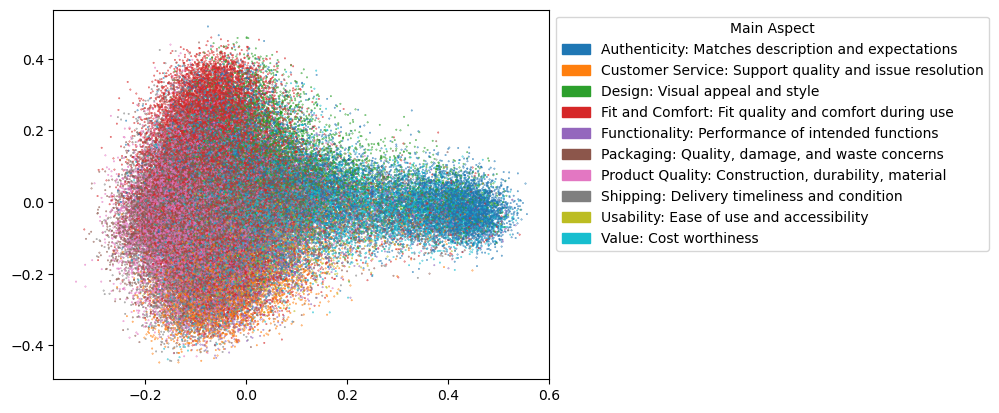

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

# Assuming 'all_reviews_sample' is a DataFrame that contains 'embeddings' and 'main_aspect' columns
# pca = PCA(n_components=2)
# pca_embeddings = pca.fit_transform(np.stack(all_reviews_sample['embeddings']))

# Convert 'main_aspect' to categorical and get the codes and unique categories
category_codes = all_reviews_sample['main_aspect'].astype('category')
codes = category_codes.cat.codes
categories = category_codes.cat.categories

# Assign a distinct color to each category using a color map
colormap = plt.get_cmap('tab10', len(categories))  # Updated method to access the colormap
colors = [colormap(i) for i in range(len(categories))]  # Create a list of colors

# Create a scatter plot
scatter = plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], s=0.1, c=[colors[code] for code in codes])

# Manually create legend handles
from matplotlib.patches import Patch
handles = [Patch(color=colors[i], label=category) for i, category in enumerate(categories)]

# Place the legend outside the plot
plt.legend(handles=handles, title="Main Aspect", loc='upper left', bbox_to_anchor=(1,1))

plt.show()


In [345]:
all_reviews_sample['x_tsne'] = tsne_embeddings[:,0]
all_reviews_sample['y_tsne'] = tsne_embeddings[:,1]

sample = all_reviews_sample.sample(n=10000, random_state=42)

fig = px.scatter(data_frame=sample,
  x=sample['x_tsne'],
  y=sample['y_tsne'],
  color=sample['main_aspect'],
  labels={'color': 'Main Aspect'},
  title='TSNE Embeddings of Reviews with Main Aspect Labels',
  hover_data={'main_aspect': True, 'year': True, 'review': True},
  height=800)

fig.update_traces(marker=dict(size=5))

fig.show()

In [347]:
# print sample of reviews for each aspect
for aspect in aspects:
  print(aspect,':')
  for i in range(5):
    print(all_reviews_sample[all_reviews_sample['main_aspect'] == aspect].iloc[i, 2])
  print()

Product Quality: Construction, durability, material :
terrible quality, not weather proof.<br />First time it rained the inside filled with condensation.  looks ridiculous
Not what I thought it was.  It is really intended for clothing and would be fine for that.  The two pieces are held together by ver small screws.  Not intended for use on canvas.
DO NOT BUY THIS TABLET.  I purchased this tablet for my autistic son who just happens to love Sprout at a major electronics chain.  I thought it would be perfect.  The content was actually fantastic...far exceeded my expectations.  But they took all that marvelous content and wrapped it up in terrible hardware.  Within two weeks the screen was black with this line down the middle.  I tried to return/exchange the product and was told that the tablet had an &#34;internal crack&#34; which is damage and not covered by the manufacturer's warranty.  First of all, I doubt the whole &#34;internal crack&#34; thing because when you change the orientat

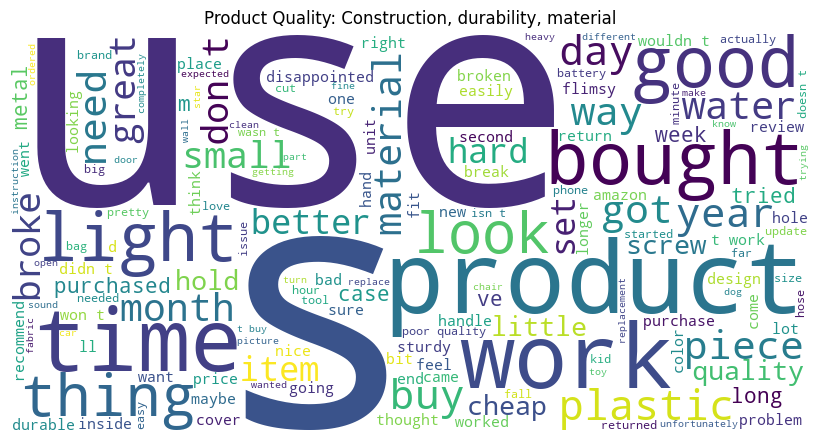

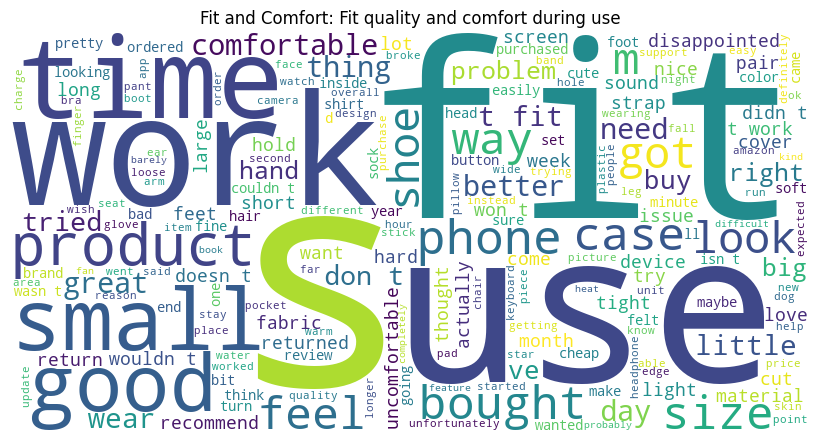

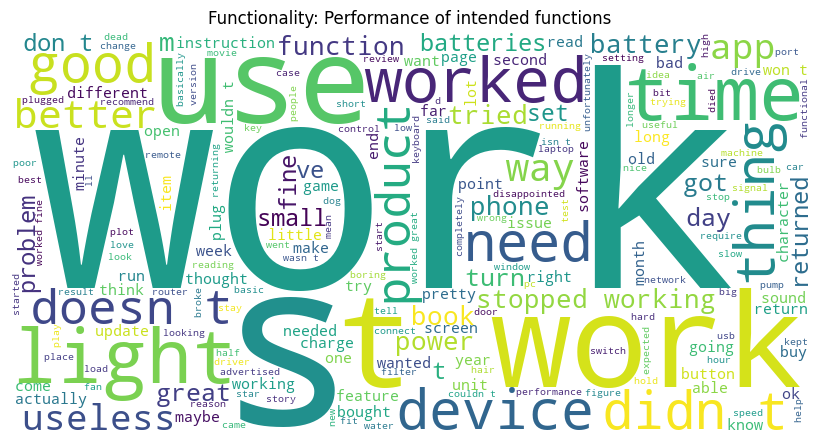

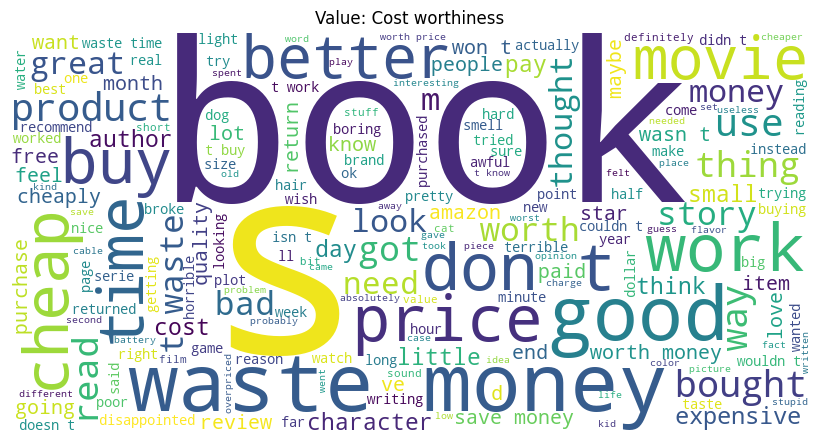

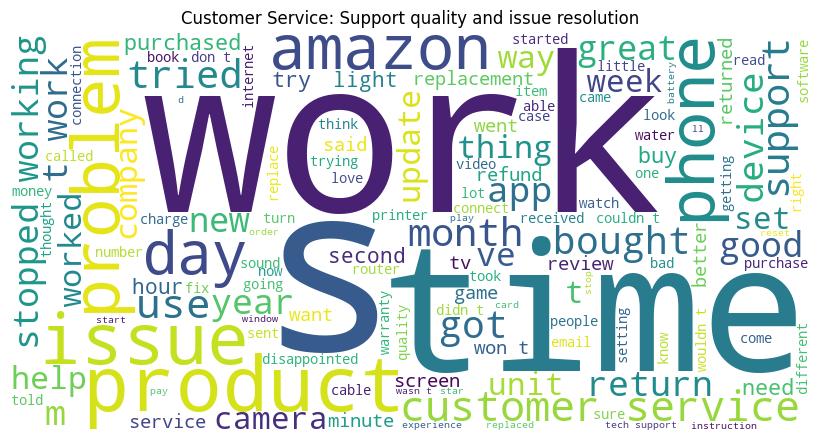

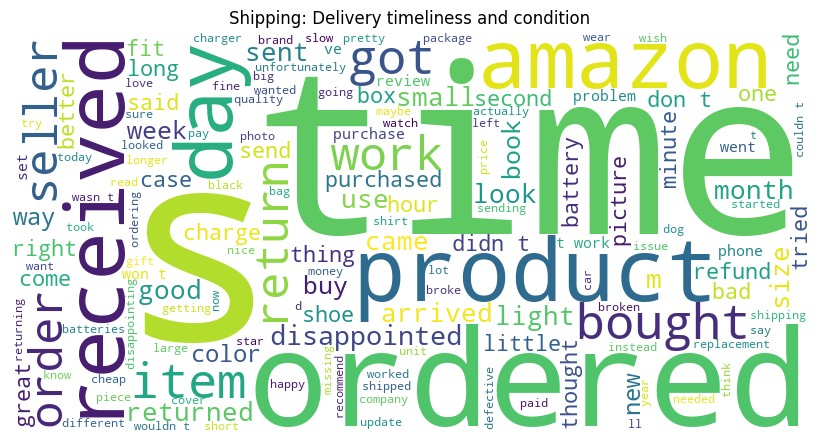

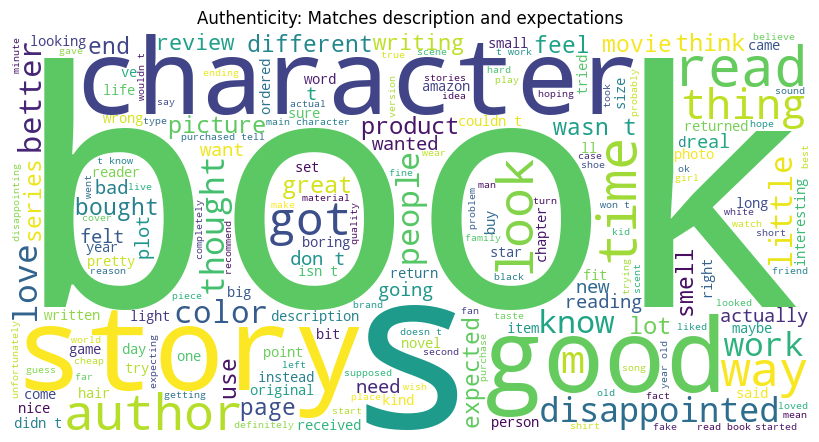

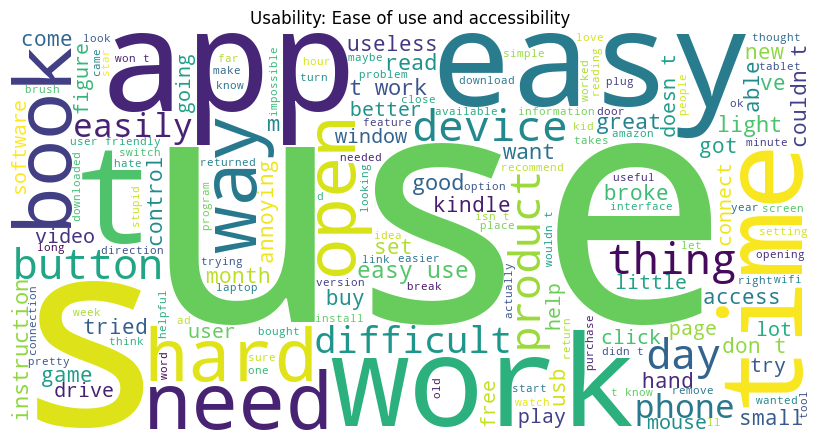

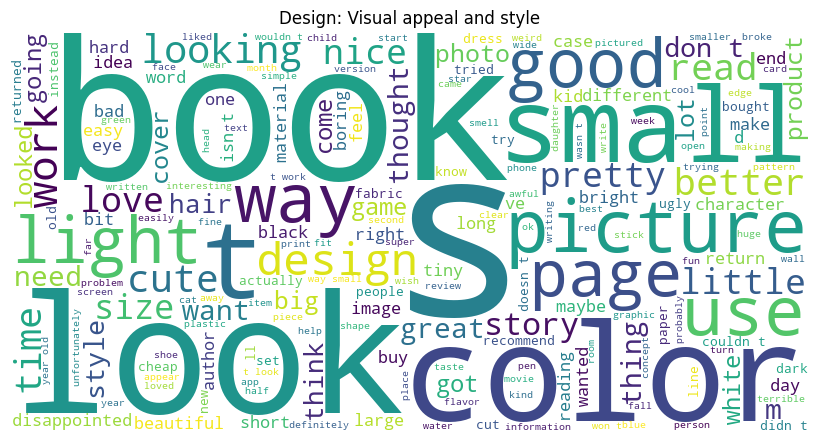

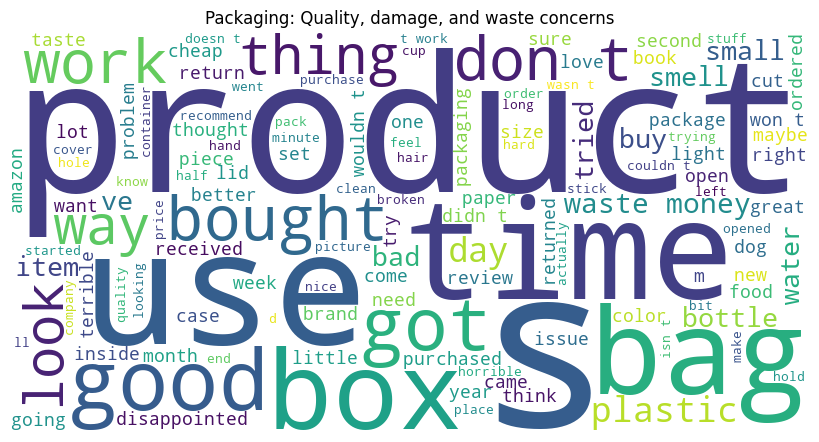

In [333]:
from wordcloud import WordCloud

for aspect in aspects:
    text = ' '.join(all_reviews_sample[all_reviews_sample['main_aspect'] == aspect]['clean_review'])
    if text:
        wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None, min_font_size=10).generate(text)
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title(aspect)
        plt.show()
    else:
        print(f"No reviews found for aspect: {aspect}")
